In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sksurv.metrics import concordance_index_censored

from sksurv.nonparametric import kaplan_meier_estimator

In [2]:
df = pd.read_csv("../Training_healthycontrol.csv")

In [3]:
df

,eid,A1BG,AAMDC,AARSD1,ABCA2,ABHD14B,ABL1,ABO,ABRAXAS2,ACAA1,...,ZHX2,ZNF174,ZNF75D,ZNF830,ZNRD2,ZNRF4,ZP3,ZP4,ZPR1,Diagnosis
0,1000266,NaN,NaN,0.40715,NaN,-0.11755,0.25745,NaN,NaN,-0.14200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1000497,NaN,NaN,0.42255,NaN,0.01375,-0.02095,NaN,NaN,0.77410,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,1000677,0.1568,0.01295,-0.31630,1.05585,-0.38540,0.00970,3.2135,0.6769,-0.23070,...,-0.0291,-0.0502,-0.2307,0.92400,0.16225,-0.3312,0.1418,-0.3423,2.5653,0
3,1000850,NaN,NaN,-0.55015,NaN,-0.25335,-0.31335,NaN,NaN,-0.84740,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1001107,-0.2110,-0.77445,0.20225,0.20750,-1.09045,-0.32760,-0.2397,-0.2388,0.64995,...,-0.0234,-0.0212,-0.1525,1.01270,-1.19675,-0.1437,-5.3070,0.0043,-0.0303,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21761,6024052,-0.1365,-0.32825,-0.62590,-0.00800,-0.49220,-0.20050,1.1230,-1.1933,1.26780,...,-0.0275,0.3982,-0.4677,-0.51045,-0.80770,-0.5196,-5.9031,-0.1250,0.0003,0
21762,6024075,0.1595,1.11965,0.14235,-0.54850,0.73410,1.67810,-2.3058,1.2812,1.06350,...,0.3143,-0.1279,-0.6946,-0.05560,1.43715,-0.2600,-0.1321,-0.1913,0.0007,0
21763,6024150,-0.1154,-0.29855,-0.35900,0.05370,NaN,-0.35270,-1.1163,-0.1071,-0.65720,...,-0.2593,0.1530,-0.2947,-0.06875,0.26890,0.5310,0.2054,0.0620,0.5324,0
21764,6024388,-0.0518,0.47975,-0.19385,-0.20240,0.70555,0.78740,2.0945,0.5587,0.70440,...,-0.1309,-0.1359,-0.1317,-0.55340,-0.54295,0.5839,0.8439,-0.1413,0.4008,0


In [4]:
protein_cols = df.columns[1:-1]

In [5]:
protein_cols

Index(['A1BG', 'AAMDC', 'AARSD1', 'ABCA2', 'ABHD14B', 'ABL1', 'ABO',
       'ABRAXAS2', 'ACAA1', 'ACADM',
       ...
       'ZFYVE19', 'ZHX2', 'ZNF174', 'ZNF75D', 'ZNF830', 'ZNRD2', 'ZNRF4',
       'ZP3', 'ZP4', 'ZPR1'],
      dtype='object', length=2923)

In [6]:
df["Diagnosis"].value_counts()

0    21128
1      638
Name: Diagnosis, dtype: int64

In [7]:
#Read columns that should be imputed (the rest are missing in more than 30% of PD participants)
protein_cols = np.loadtxt("../columns_30pd.txt", dtype=str).tolist()
all_protein_cols = np.loadtxt("../all_proteins.txt", dtype=str).tolist()
columns_drop = set(all_protein_cols) - set(protein_cols)
df = df.drop(columns=columns_drop)

In [8]:
path_rds_diagnoses = "/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/UKBB_diagnoses_Jun2025/processed/diagnoses_extracted"
pd_df =  pd.read_csv(f"{path_rds_diagnoses}/Parkinson.csv").iloc[:, 1:]


In [9]:
# Create a dictionary: {eid: date_diagnosis}
eid_to_date = pd_df.set_index("eid")["date_diagnosis"].to_dict()

In [10]:
df["date_diagnosis"] = df["eid"].map(eid_to_date)

In [11]:
df[df["Diagnosis"] == 1]["date_diagnosis"].isna().sum()

0

In [12]:
df["date_diagnosis"] = pd.to_datetime(df["date_diagnosis"], errors='coerce')
df["date_diagnosis"].fillna(pd.Timestamp("2024-09-30"), inplace=True)


In [13]:
demo = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/demographics_processed.csv")
visit_dates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/Visit_dates.csv")

In [14]:
covariates = pd.read_csv("/rds/general/user/meb22/projects/ukbiobank/live/ukbiobank/data_2025/proteomics/Processed_all_covariates.csv").iloc[:,1:]

In [15]:
covariates_test_cols=["Age", "Sex", "Ethnicity", "smoking", "alcohol", "Season" , "fasting_time", "sample_age"]

In [16]:
df_dates = pd.merge(df, visit_dates[["eid","p53_i0"]], on="eid")

In [17]:
import pandas as pd

# Ensure both columns are datetime
df_dates["p53_i0"] = pd.to_datetime(df_dates["p53_i0"])
df_dates["date_diagnosis"] = pd.to_datetime(df_dates["date_diagnosis"])

# Compute difference in days and convert to years
df_dates["time_to_diagnosis"] = (df_dates["date_diagnosis"] - df_dates["p53_i0"]).dt.total_seconds() / (365.25*24*3600)

# Optional: round to 2 decimal places
df_dates["time_to_diagnosis"] = df_dates["time_to_diagnosis"].round(2)


In [25]:
subset_df = df_dates[~((df_dates["Diagnosis"] == 1) & (df_dates["time_to_diagnosis"] <= 2))]


In [26]:
subset_df["Diagnosis"].value_counts()

0    21128
1      413
Name: Diagnosis, dtype: int64

In [27]:
subset_df = subset_df.drop(columns=["date_diagnosis","p53_i0"])

In [28]:
subset_df = pd.merge(
    subset_df,
    covariates[["eid"] + covariates_test_cols],
    on="eid",

)


In [29]:
subset_df["sample_age"]

0        4200.0
1        4842.0
2        4203.0
3        4913.0
4        4139.0
          ...  
21536    5030.0
21537    5356.0
21538    5298.0
21539    4414.0
21540    5218.0
Name: sample_age, Length: 21541, dtype: float64

In [30]:
# Example for covariates_test_cols
for col in covariates_test_cols:
    if subset_df[col].dtype == "object":
        subset_df[col] = subset_df[col].astype("category").cat.codes


In [31]:
import pandas as pd
from lifelines import CoxPHFitter

all_protein_summaries = []

for protein in protein_cols:
    cols = [protein] + covariates_test_cols + ["time_to_diagnosis", "Diagnosis"]
    df_model = subset_df[cols].dropna()
    
    cph = CoxPHFitter()
    cph.fit(df_model, duration_col="time_to_diagnosis", event_col="Diagnosis")
    
    # Extract only the protein row safely
    protein_row = cph.summary.loc[[protein]].copy()
    protein_row["Protein_tested"] = protein
    all_protein_summaries.append(protein_row)

# Concatenate all proteins into one DataFrame
protein_results_df = pd.concat(all_protein_summaries)

# Drop index (covariate names) to avoid duplicates
protein_results_df = protein_results_df.reset_index(drop=True)

# Keep only the useful columns
protein_results_df = protein_results_df[["Protein_tested", "coef", "exp(coef)", 
                                         "se(coef)", "coef lower 95%", "coef upper 95%", "p"]]

# Now sorting works safely
protein_results_df = protein_results_df.sort_values("p")

print(protein_results_df.head())

     Protein_tested      coef  exp(coef)  se(coef)  coef lower 95%  \
763           ITGAV -1.859489   0.155752  0.256795       -2.362798   
110            BAG3 -0.571873   0.564467  0.084469       -0.737428   
298         CLEC10A -0.727158   0.483281  0.122761       -0.967766   
957            NEFL  0.475896   1.609455  0.088066        0.303289   
1219         SETMAR -0.635601   0.529617  0.122604       -0.875902   

      coef upper 95%             p  
763        -1.356181  4.449103e-13  
110        -0.406318  1.285636e-11  
298        -0.486550  3.154688e-09  
957         0.648502  6.523062e-08  
1219       -0.395301  2.169904e-07  


In [32]:
from statsmodels.stats.multitest import multipletests

# Make sure you have a p-value column
pvals = protein_results_df["p"].values  

# Apply FDR correction
reject, pvals_corrected, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

# Add results back to dataframe
protein_results_df["p_fdr"] = pvals_corrected
protein_results_df["significant_fdr05"] = reject


In [33]:
protein_results_df[protein_results_df["significant_fdr05"] == True]["Protein_tested"].nunique()

69

In [34]:
protein_results_df.to_csv("PDcox.csv")

In [45]:
cph

<lifelines.CoxPHFitter: fitted with 20564 total observations, 20166 right-censored observations>

In [35]:
df = pd.read_csv("PDcox.csv")

In [36]:
protein_cox_pd = df[df["p_fdr"] <0.05]["Protein_tested"].unique().tolist()

In [37]:
# Write to a file
with open("proteins_cox_PD_list.txt", "w") as f:
    for protein in protein_cox_pd:
        f.write(protein + "\n")

In [42]:
protein_results_df= df

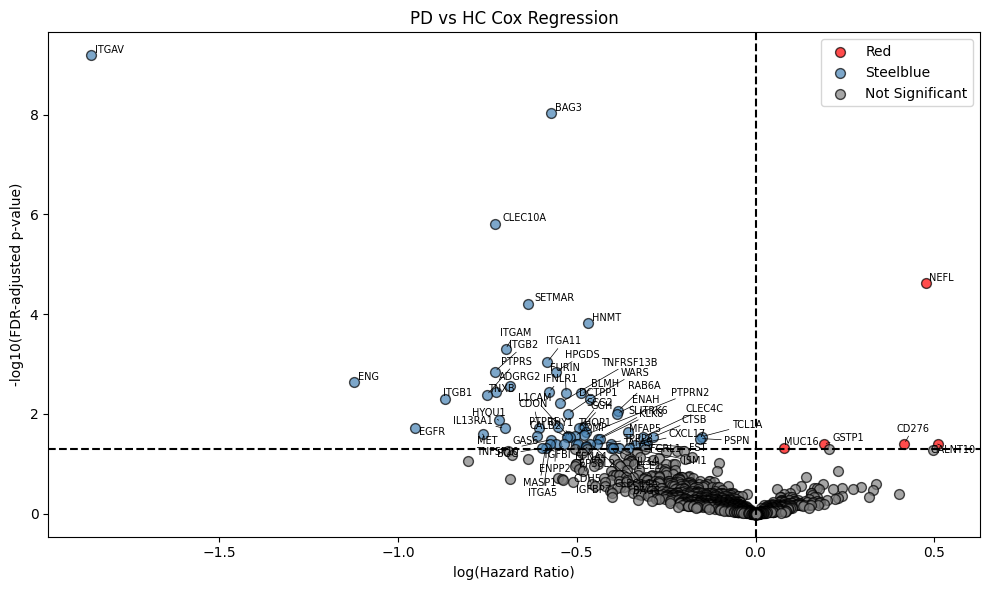

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from adjustText import adjust_text

# Compute -log10(FDR) if not already done
protein_results_df['neg_log10_fdr'] = -np.log10(protein_results_df['p_fdr'])
protein_results_df['logHR'] = protein_results_df['coef']  # use logHR from coef

# Assign significance colors
def color_sign(row):
    if row['significant_fdr05']:
        return 'red' if row['logHR'] > 0 else 'steelblue'
    else:
        return 'grey'

protein_results_df['color'] = protein_results_df.apply(color_sign, axis=1)

# Plot
plt.figure(figsize=(10, 6))

for color in ['red', 'steelblue', 'grey']:
    subset = protein_results_df[protein_results_df['color'] == color]
    plt.scatter(
        subset['logHR'],
        subset['neg_log10_fdr'],
        label=color.capitalize() if color != 'grey' else 'Not Significant',
        color=color,
        alpha=0.7,
        edgecolors='k',
        s=50
    )

# Reference lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black")
plt.axvline(0, linestyle="--", color="black")

# Annotate significant proteins
texts = []
sig_prots = protein_results_df[protein_results_df['significant_fdr05'] == True]

for _, row in sig_prots.iterrows():
    texts.append(
        plt.text(row['logHR'], row['neg_log10_fdr'], row['Protein_tested'], fontsize=7)
    )

adjust_text(texts, arrowprops=dict(arrowstyle="-", color="black", lw=0.5))

# Labels and style
plt.xlabel("log(Hazard Ratio)")
plt.ylabel("-log10(FDR-adjusted p-value)")
plt.legend()
plt.title("PD vs HC Cox Regression")
plt.tight_layout()
plt.show()


In [4]:
df = pd.read_csv("PDcox.csv")

In [13]:
df

,Unnamed: 0,Protein_tested,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,p,p_fdr,significant_fdr05
0,763,ITGAV,-1.859489,0.155752,0.256795,-2.362798,-1.356181,4.449103e-13,6.500139e-10,True
1,110,BAG3,-0.571873,0.564467,0.084469,-0.737428,-0.406318,1.285636e-11,9.391571e-09,True
2,298,CLEC10A,-0.727158,0.483281,0.122761,-0.967766,-0.486550,3.154688e-09,1.536333e-06,True
3,957,NEFL,0.475896,1.609455,0.088066,0.303289,0.648502,6.523062e-08,2.382548e-05,True
4,1219,SETMAR,-0.635601,0.529617,0.122604,-0.875902,-0.395301,2.169904e-07,6.340458e-05,True
...,...,...,...,...,...,...,...,...,...,...
1456,1225,SFTPA2,0.000268,1.000268,0.086862,-0.169978,0.170514,9.975418e-01,9.999113e-01,False
1457,615,GPC5,-0.000163,0.999837,0.081676,-0.160245,0.159919,9.984070e-01,9.999113e-01,False
1458,1312,SUSD2,0.000217,1.000217,0.157636,-0.308744,0.309178,9.989018e-01,9.999113e-01,False
1459,312,CLPP,-0.000029,0.999971,0.047745,-0.093608,0.093551,9.995231e-01,9.999113e-01,False


In [12]:
df[(df["coef"] > 0.5) & (["p_fdr"] < 0.05)]

TypeError: '<' not supported between instances of 'list' and 'float'